# Part 1

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('framingham_heart_disease.csv')

### Section 1- Research question
We would like to explore the relations between: Number of cigaretes per day (discrete), total cholesterol (continous), diaBP (diastolic BP) and sysBP (systolic BP - continous). <br>
Hence, our research question would be:
**What are the effects of number of cigaretes per day, total cholesterol and diaBP over sysBP**

In [4]:
df.dropna(subset=['cigsPerDay', 'totChol', 'diaBP', 'sysBP'], inplace=True)

### Section 2

In [81]:
df_train, df_test, y_train, y_test = train_test_split(df[['cigsPerDay', 'totChol', 'diaBP']], df[['sysBP']], test_size=0.9519115171916326, random_state=42)

### Section 3.a

<AxesSubplot:>

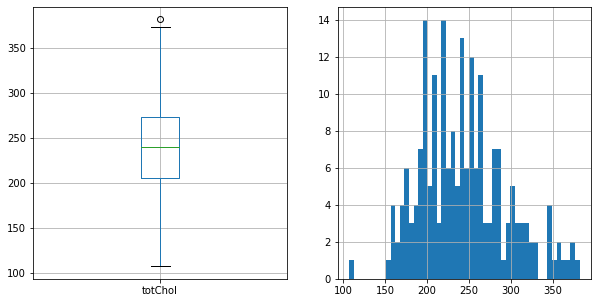

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df_train.boxplot(column=['totChol'], ax=axes[0])
df_train['totChol'].hist(bins=50, ax=axes[1])

<AxesSubplot:>

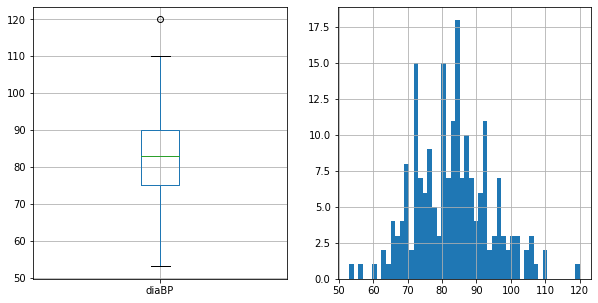

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df_train.boxplot(column=['diaBP'], ax=axes[0])
df_train['diaBP'].hist(bins=50, ax=axes[1])

<AxesSubplot:>

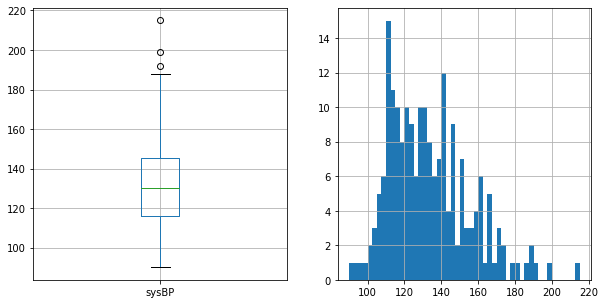

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
y_train.boxplot(column=['sysBP'], ax=axes[0])
y_train['sysBP'].hist(bins=50, ax=axes[1])

In [9]:
df_train.groupby('cigsPerDay').count().rename(columns={'totChol': 'count'})[['count']].transpose()

cigsPerDay,0.0,1.0,2.0,3.0,4.0,5.0,9.0,10.0,13.0,15.0,18.0,20.0,25.0,30.0,35.0,40.0,43.0,60.0
count,88,6,1,6,1,3,9,2,1,12,1,42,2,13,3,7,2,1


### Section 3.b
<ins>Missing values:</ins> We had NaN values for some of the columns but we took care of it by droping the rows containing them before section 2. Other methods of taking care of them would be to replace them with the average or median for example. Since we want to get a grasp of the relations between explaining variables to the explained variable, we would like to first use non-missing values to try and see the closest estimation for the real relationship.
<br><br>
<ins>abnormal data:</ins> There are few outliers in each of the continous variables and it is always after the upper whisker  and not below the lower whisker.Moreover, when looking at the cigsPerDay histogram we can see that there are many people not smoking (0 per day) and than many people smoking 20 cigaretes per day with lower volumes in between. This observation could indicate anomally which could result from the way the data was collected or other fenomenas related to people who smoke.
<br><br>
<ins>Distribution of the variables:</ins> We can see that the histogram of totChol and diaBP resembles normal distribution, and the sysBP's histogram resembles chi-squre or gamma distribution since it seems to have a heavy tail in contrast to the first two variables.
Estimating the distribution of cigsPerDay is harder since it is discrete but it looks like multinomial with higher probabilities for 0 & 20.

### Section 3.c

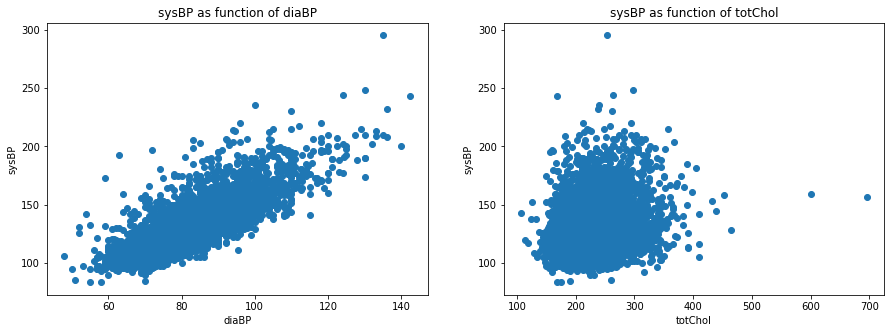

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for i, col in enumerate(['diaBP', 'totChol']):
    axes[i].scatter(df[col], df['sysBP'])
    axes[i].set_title(f'sysBP as function of {col}')
    axes[i].set_ylabel('sysBP')
    axes[i].set_xlabel(f'{col}')

<ins>Concolusion:</ins> It looks like diaBP column has strong positive correlation with sysBP, while the totChol has almost no correlation at all to sysBP.

### Section 3.d

Text(0, 0.5, 'sysBP')

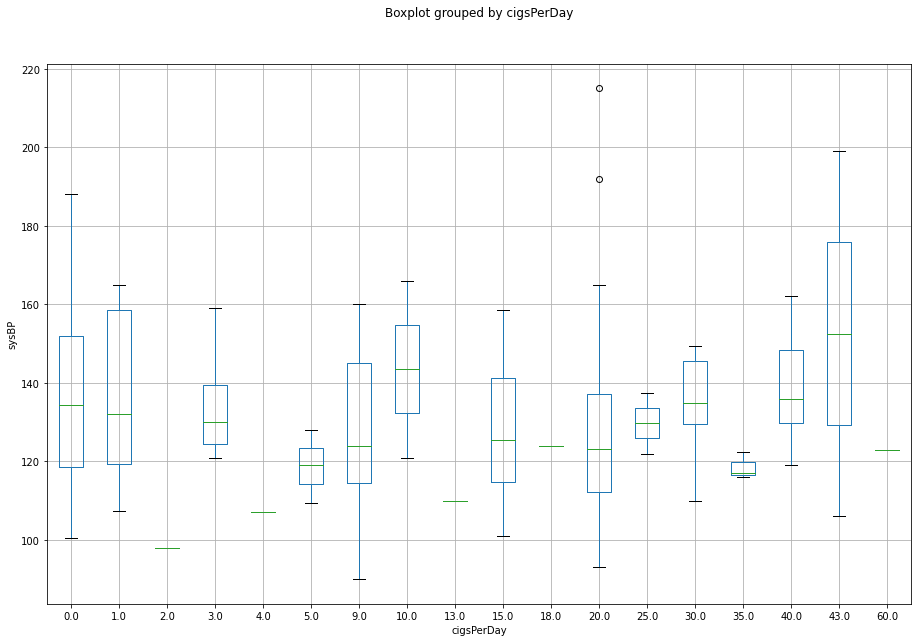

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
df_cigsSysBp = pd.concat([df_train[['cigsPerDay']], y_train], axis=1)
df_cigsSysBp.boxplot(by='cigsPerDay', ax=axes)
axes.set_title('')
axes.set_xlabel('cigsPerDay')
axes.set_ylabel('sysBP')

### Section 4

In [12]:
X = sm.add_constant(df_train)
model = sm.OLS(y_train,X)
results = model.fit()
results.params

const        -6.795017
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64

As we concluded from the scatter plots, we can see that diaBP has the largest absolute value of multiplier in $\hat{\beta}$ while cigsPerDay and totChol's multipliers are closer to zero.

In [13]:
for col in df_train.columns:
    temp_df = df_train.copy()
    temp_df[col] += 1
    X = sm.add_constant(temp_df)  # add bias
    model = sm.OLS(y_train,X)
    temp_results = model.fit()
    print(col)
    print(temp_results.params, '\n')

cigsPerDay
const        -6.792589
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64 

totChol
const        -6.850756
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64 

diaBP
const        -8.315941
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64 



We can see that for each column we increased by one unit, the constants (bias) multiplier's absolute value 

### Section 5

In [14]:
def anova_table(model):
    dict_anova = {'Source of Variation': ['Regression', 'Residual error', 'Total'],
                  'DF':[4, model.nobs - 4, model.nobs - 1],
                  'SS': [(model.mse_model)*3, model.mse_resid*(model.nobs - 4),model.mse_total*(model.nobs - 1)],
                  'MS': [model.mse_model, model.mse_resid, model.mse_total],
                  'F': [model.mse_model/model.mse_resid, '-', '-'],
                  'F-Pvalue': [model.f_pvalue,'-', '-']
                 }
    r = ((model.mse_model)*3) /(model.mse_total*(model.nobs - 1)) 
    print('**Anova Table**')
    print(pd.DataFrame(dict_anova))
    print()
    print('**R^2**')
    print(r)
    print()
    print('**R^2 adj**')
    print(1-((model.nobs - 1)/(model.nobs - 4))*(1-r))

In [15]:
anova_table(results)

**Anova Table**
  Source of Variation     DF           SS            MS           F F-Pvalue
0          Regression    4.0  60707.27209  20235.757363  113.108493      0.0
1      Residual error  196.0  35065.52291    178.905729           -        -
2               Total  199.0  95772.79500    481.270327           -        -

**R^2**
0.6338676039469487

**R^2 adj**
0.6282635366604223


### Section 6

In [16]:
results.conf_int()

,0,1
const,-22.772409,9.182376
cigsPerDay,-0.149387,0.144531
totChol,0.018248,0.093230
diaBP,1.346634,1.695215


In [17]:
df_all = df[['cigsPerDay', 'totChol', 'diaBP']]

In [18]:
X = sm.add_constant(df_all)
model_all = sm.OLS(df[['sysBP']],X)
results_all = model.fit()
results_all.params

const        -8.315941
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64

As expected, we can see that all $\forall j\in[0,3]: \hat{\beta_j}$ is in the confidence interval estimated based on the sub-sample.

### Section 7
We saw in the ANOVA table the the p-value for F test was 0, meaning we will reject the null hypothesis, hence the coefficients are different from zero.

### Section 8

In [19]:
y_predicted = results.predict(sm.add_constant(df_train))

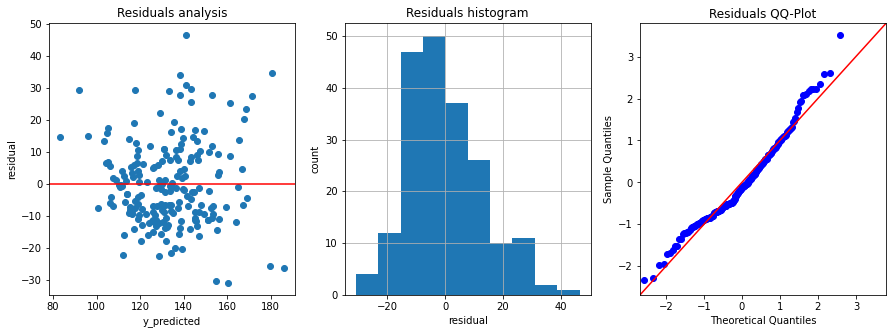

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Residuals plot
axes[0].scatter(y_predicted, results.resid)
axes[0].axhline(0,0, color='r')
axes[0].set_title('Residuals analysis')
axes[0].set_xlabel('y_predicted')
axes[0].set_ylabel('residual')

# Histogram for the residuals
results.resid.hist(ax=axes[1])
axes[1].set_title('Residuals histogram')
axes[1].set_xlabel('residual')
axes[1].set_ylabel('count')

# QQ-Plot for the residuals
sm.qqplot(results.resid, norm, fit=True, line="45", ax=axes[2])
axes[2].set_title('Residuals QQ-Plot')

plt.show()

<ins>Linearity assumption:</ins> As we can see in the residual analysis plot, there is no pattern or symmetry of the residuals around e=0 line. This could indicate that the linear model has catched most of the information but the noise itself, hence linearity is plausable.
<br><br>
<ins>Homoscedaticity:</ins> Also from the residual analysis plot we can deduce that the assumption of homosecedaticity is not that plausable, since the residuals are not equally spread over the plot.
<br><br>
<ins>Residual's distribution:</ins> As we can see from the histogram and the QQ-Plot, the assumption for normal distribution over the residuals is plausable.

### Section 9

In [30]:
def calc_ci(sign, x_i, y_i, sigma_squared, ci_t_percentile, C):
    return y_i + sign*(ci_t_percentile*np.sqrt(sigma_squared*(1+x_i.T@C@x_i)))

In [68]:
new_df = pd.concat([df_test, y_test], axis=1).sample(1000)
new_y_test = new_df[['sysBP']]
new_df = new_df[['cigsPerDay', 'totChol', 'diaBP']]

y_predicted = results.predict(sm.add_constant(new_df))

In [69]:
# Since the variance is unknown we will compute it using the unbiased estimator as shown in tutorial 5
dof = len(df_train)-2
sigma_squared = np.dot(results.resid.to_numpy().T,results.resid.to_numpy())/(len(new_df)-4)
ci_t_percentile = t(df=dof).ppf(0.95)
C = np.linalg.inv(np.matmul(new_df.to_numpy().T,new_df.to_numpy()))  # C = (X.T * X)^-1
CI = [(calc_ci(-1, x_i, y_i, sigma_squared, ci_t_percentile, C),
      calc_ci(1, x_i, y_i, sigma_squared, ci_t_percentile, C)) for (x_i,y_i) in zip(new_df.to_numpy(),y_predicted)]

In [70]:
sum([c_l<y_i[0]<c_u for ((c_l, c_u), y_i) in zip(CI, new_y_test.to_numpy())])/len(CI)

0.617

As we can see, not all real values actually fits into the confidence intervals. This could be indicating that our linearity assumption about the true model is not accurate and we did not capture all of the information from the data relevant for the predictions. <br>
Moreover, this results correlates to the $R^2$ measure we saw in section 5, which was ~0.62. Implicating our linear model was able to explain ~0.6 of the relations.

### Section 10
We will use both cross validation and Mallow Cp to evaluate which model is better.

In [74]:
poly = PolynomialFeatures(interaction_only=True,include_bias=True)
interactions_array = poly.fit_transform(df_train)

regular_array = np.concatenate([np.ones((200,1)), df_train.to_numpy()], axis=1)
y_array = [y[0] for y in y_train.to_numpy()]

clf = LinearRegression()

In [75]:
scores = cross_val_score(clf, regular_array, y_array, cv=5)
print(f'CV mean for linear model: {scores.mean()}, CV std: {scores.std()}')

CV mean for linear model: 0.5930852758952645, CV std: 0.07587104362026717


In [76]:
scores = cross_val_score(clf, interactions_array, y_array, cv=5)
print(f'CV mean for interaction model: {scores.mean()}, CV std: {scores.std()}')

CV mean for interaction model: 0.5882636099787181, CV std: 0.08362270119533186


In [83]:
def get_mallow_cp(clf, y_true, sigma_squared, num_features, array):
    # Mallow Cp = RSE + number_of_features*sigma_squared
    RSE = len(y_true)*mean_squared_error(y_array, clf.predict(array))
    return RSE + 2*num_features*sigma_squared

In [84]:
clf_linear = LinearRegression()
clf_linear.fit(regular_array, y_array)
linear_num_features = 4  # bias and three variables

clf_interactions = LinearRegression()
clf_interactions.fit(interactions_array, y_array)
interatction_num_features = 7  # bias and 6 variables

print(f'Mallow-Cp for linear model: {get_mallow_cp(clf_linear, y_array, sigma_squared, linear_num_features, regular_array)}, Mallow-Cp for interactions model: {get_mallow_cp(clf_interactions, y_array, sigma_squared, interatction_num_features, interactions_array)}')

Mallow-Cp for linear model: 35347.17369647377, Mallow-Cp for interactions model: 34286.316243456735


We can see that the regular linear model recieved higher scores both for Mallow-Cp and the mean over 5-fold cross validation. This could indicate that the linear model describes the data better than the interactions model.
Nevertheless, the differences both for the 5-fold mean and the Mallow-Cp are not big so this is not conclusive.

# Part 2

### Section 1
For this part we will choose the same explaining variabled (cigsPerDay, totChol, diaBP) and the explained variable would be TenYearsCHD (which is binary, indicating having disease or not).<br>
Hence, our research question would be:
**What are the effects of number of cigaretes per day, total cholesterol and diaBP over TenYearCHD**

### Section 2

In [85]:
df_train, df_test, y_train, y_test = train_test_split(df[['cigsPerDay', 'totChol', 'diaBP']], df[['TenYearCHD']], test_size=0.9519115171916326, random_state=42)

### Section 3
We will explore only the explained variable - TenYearCHD, since we explored all others in the first part